# Introduction to hax, part III

Last updated April 2018.

This tutorial shows several advanced features of hax you may not need everyday, but will be quite useful when you do:
  * Custom minitree creation
  * Looping directly over pax' ROOT files
  * Accessing slow control data
  * Out-of-core computations

## Setup

Let's start up hax and select an example neutron generator dataset, as in the first tutorial.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline   

import hax
hax.init()

In [2]:
ds = hax.runs.tags_selection(include='sciencerun1')
ds = ds[
    (ds['source__type'] == 'neutron_generator')
    & (ds['location'] != '')
]

our_dset = ds.iloc[-1].number
print(our_dset)

10058


## Selecting your own variables with custom minitrees

So far we've been working with pre-made minitrees. These won't always be sufficient. Fortunately, extracting your own minitree is easy: you write a small TreeMaker class defining just one function: `extract_data`. This takes an `event` (the pax/ROOT object documented [here](http://xenon1t.github.io/pax/format.html)) and returns a dictionary with the data you want to save for that event. 

(It's ok if the dictionary is not the same for every event, missing values will become NaNs).

For example, suppose your are interested in the number of hits in the main S1 and S2. You can set up your TreeMaker like so:

In [3]:
class HitsInMainPeaks(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.n_hits']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(s1_n_hits=s1.n_hits,
                    s2_n_hits=s2.n_hits)

Then you can read in data like this:

In [4]:
data = hax.minitrees.load(our_dset, treemakers=[HitsInMainPeaks, 'Basics'])
data.head(5)

INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/aalbers/hax/examples/pax_event_class-d83c1ca54db19e86ab8c8b3f67cdd5a3_cpp.so
Run 10058: Making HitsInMainPeaks minitree: 100%|██████████| 88675/88675 [02:22<00:00, 623.76it/s] 
DEBUG:hax.__init__] Extraction completed, now concatenating data
DEBUG:hax.minitrees] Retrieved HitsInMainPeaks minitree data for dataset 10058
DEBUG:hax.minitrees] Found minitree at /project/lgrandi/xenon1t/minitrees/latest/170530_1626_Basics.root
DEBUG:hax.minitrees] Found minitree at ./170530_1626_HitsInMainPeaks.root
DEBUG:hax.minitrees] Found minitree at /project/lgrandi/xenon1t/minitrees/latest/170530_1626_Basics.root
DEBUG:hax.minitrees] Removing weird index column


,run_number,event_number,drift_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s1_range_50p_area,s2,s2_area_fraction_top,s2_range_50p_area,x_pax,y_pax,z,s1_n_hits,s2_n_hits
0,10058,0,570770.0,0,16.357983,546.603638,10.832104,0.0,3194.202148,0.133966,81.003211,116676.382812,0.629944,1963.931213,20.356758,41.538960,-75.833534,339.0,8307.0
1,10058,1,702720.0,0,0.000000,178930.203125,14.718580,0.0,16968.550781,0.084638,79.688278,627856.250000,0.640382,2349.883325,11.388213,7.113688,-93.417023,419.0,9190.0
2,10058,2,257890.0,0,0.000000,99753.031250,4.205910,0.0,3750.861328,0.245517,78.351161,109405.625000,0.638187,1207.639449,25.199934,39.344578,-34.139549,340.0,4683.0
3,10058,3,265680.0,0,7.166865,285972.718750,5.473463,0.0,9991.227539,0.249268,91.117324,760470.000000,0.631949,1307.664620,12.842582,43.166271,-35.177635,534.0,7883.0
4,10058,4,185040.0,0,0.000000,141575.781250,6.880793,0.0,3498.198730,0.265364,81.976762,199562.234375,0.640393,1055.714670,23.641584,38.550804,-24.431654,329.0,4160.0


This might trigger a C++ class compilation if you run it for the first time. Then, you'll get a progressbar which runs for about two minutes while your minitree is making. 

After running the above cell, a file `170530_1626_HitsInMainPeaks.root` will have appeared in the current directory:

In [5]:
!ls *.root

170530_1626_HitsInMainPeaks.root


The next time you run the cell, the information is taken from this file instead of rebuilt from scratch.

What if you change something in your TreeMaker? You can add force_reload=True to `hax.minitrees.load` to rebuild your tree (but it might do it twice due to an implementation detail we've been too lazy to fix). A gentler approach is to simply increment the version number of your TreeMaker. `hax` will notice the minitrees are outdated and rebuild them when you try to load your data. (try it!)

A few things we did not cover here:
  * You can create minitrees that have a variable number of rows per event using the `MultipleRowExtractor` treemaker base class. For the specific case of extracting one row per **peak** there is the `PeakExtractor` class, which has its own tutorial notebook.
  * A few things listed in the [pax event format](http://xenon1t.github.io/pax/format.html) are actually not real fields, but methods or properties, which no longer exist in the ROOT representation. Thus you can't use them. You can recognize them by not having a default value listed; when in doubt, check the [source code](https://github.com/XENON1T/pax/blob/master/pax/datastructure.py).
  * Some fields such as `peaks.area_per_channel` are **array-valued**, and take a bit more effort to load. You must add a `*` in the branch selection (so `peaks.area_per_channel*`). To operate on this data, you might first have to call `np.array(list(...))` on it to coerce it out of some arcane pyROOT buffer type. Finally, if you want to pass array-valued data out of your minitree, you need to set a special flag, see the separate tutorial notebook on this. Even if you manage this, be aware that pandas dataframes do not handle array-valued data nicely at all (unlike numpy record arrays). Personally I avoid using minitrees to extract e.g. sum waveforms, instead resorting to direct loops over ROOT files.

## Looping directly over ROOT files

If you don't like writing your own TreeMaker, or you just want to be 'closer to the ground', you can always just loop over each of the events in the ROOT files themselves. This takes just a few lines of code to setup (look up filename, get TFile, get tree, loop over entries, ....) but hax can save you this small trouble too.

If you define a function, hax will take care of executing it over all events in (one or more) datasets using `hax.paxroot.loop_over_datasets` or `hax.paxroot.function_results_datasets`. The 'event' your function gets is a pax/ROOT Event object documented [here](http://xenon1t.github.io/pax/format.html#event).

Here is a small (and silly!) example that counts how many events have more than 4 S1s:

In [6]:
counter = 0

def count_many_s1s(event):
    global counter   # Need this in pyton to modify variable outside of function
    if len(event.s1s) > 4:
        counter += 1

hax.paxroot.loop_over_datasets([our_dset], count_many_s1s, 
                               # This makes it go a bit faster, we don't need all the fancy variables:
                               branch_selection=['s1s'])
print("We found %d events with more than 4 S1s" % counter)

Run 10058: : 100%|██████████| 88675/88675 [00:02<00:00, 40358.72it/s]

We found 441 events with more than 4 S1s


Another silly example: find the first event whose main s1 area rounds to 70 pe:

In [7]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise hax.paxroot.StopEventLoop    # Special magic that aborts the loop immediately

hax.paxroot.loop_over_dataset(our_dset, find_s1_70pe, branch_selection='basic')

Run 10058: :  17%|█▋        | 15454/88675 [00:13<00:49, 1464.61it/s]

Event 15572 has a main S1 with area 69.63253021240234 pe


## Accessing Slow control information

Slow control information (such as voltages and pressures) is stored in a separate database. Hax can access this for you with `hax.slow_control`:

INFO:requests.packages.urllib3.connectionpool] Starting new HTTPS connection (1): xenon1t-daq.lngs.infn.it
DEBUG:requests.packages.urllib3.connectionpool] "GET /slowcontrol/GetSCData?name=XE1T.GEN_HEINZVMON.PI&StartDateUnix=1496161618&QueryType=lab&EndDateUnix=1496165220&api_key=ssn1sslkvdhittoywjk88w9cmbxf4fmprn68r8hm&username=slowcontrolwebserver HTTP/1.1" 200 3577


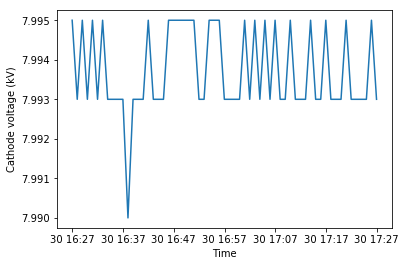

Run 10058: :  17%|█▋        | 15454/88675 [00:30<02:24, 507.64it/s]

In [8]:
cathode_vs = hax.slow_control.get('cathode', our_dset)
plt.plot(cathode_vs)
plt.xlabel("Time")
plt.ylabel("Cathode voltage (kV)")

  * The first argument must be something that matches a single slow control variable, or a list of such things (in which case you get a pandas DataFrame back rather than a pandas Series, as you get now). For a list of variables, see [here](https://github.com/XENON1T/hax/blob/master/hax/sc_variables.csv). 
  * The second argument is the run number/name. You can't call this for more than one run at a time. You also can't lower the resolution of the datapoints, so please don't write a loop to fetch this for all datasets... Keep in mind the average voltage is in the run doc (see the previous tutorial).
  * Sometimes you get an HTTPError here; just try again.

# Out of core computations

What if you want to make a cs1/cs2 spectrum of all events? You can't use preselections to make this data fit into RAM. You could write a for loop over datasets, adding to a histogram on each pass, but that's tedious, and you'd have to write your own parallelization code to get it fast. Hax has some out-of-core functionality for this, using [dask](http://dask.pydata.org/en/latest/) and [multihist](https://github.com/JelleAalbers/multihist).

First, select all SR1 6.8.0 background datasets as in the second tutorial.

In [11]:
hax.init(pax_version_policy='6.8.0',
         minitree_paths=['.', '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0'])

ds = hax.runs.tags_selection(include='sciencerun1')
ds = ds[
    (ds['source__type'] == 'none')
    & (ds['location'] != '')
]
len(ds)

6414

Now, let's prepare the delayed loading.  I'll load on the first 1000 datasets, but it won't take more memory to load the full 6414 (just more time).

In [12]:
# Small monkeypatch to avoid expensively checking if each run is an MC dataset. 
# You can omit this, but then this will take a while. We should fix this..
hax.runs.is_mc = lambda x: (False, None)

data = hax.minitrees.load(ds.number[:1000], 'Corrections', delayed=True)

Notice relatively little seems to actually happen. Under the hood, it loaded one minitree (to know which columns to expect), but for the others it created "delayed objects" and put some interface over them to make them behave like a dataframe -- a Dask dataframe.

You can make the delayed objects real and force the data to a real pandas Dataframe using `data.compute()`, but of course this eats your RAM. The point here is that you don't have to.

You can manipulate the Dask dataframe with the pandas API and/or the hax.cuts functions

In [13]:
data['r'] = (data.x**2 + data.y**2)**0.5
data = hax.cuts.below(data, 'r', 40)

r below 40 selection readied for delayed evaluation


You can call .head() to figure out if your aliases / cuts have worked (this will only require loading one minitree):

In [14]:
data['r'].head()

0     35.578952
6     38.476476
8     23.548781
9     29.401059
12    25.650402
Name: r, dtype: float64

When you're ready, you can create histograms with the multihist package. This will finally load the data, and it will take a few minutes. Notice we pass the n_workers option to parallelize the loading. Using 250,000-bin histograms is not a great idea in general, by the way...

In [15]:
from multihist import Histdd
mh = Histdd(data,
            dimensions=[('cs1', np.logspace(0, 5, 500)),
                        ('cs2', np.logspace(1, 7, 500))],
            compute_options=dict(num_workers=4))
print("Histogrammed %d events" % mh.n)

Histogrammed 9566125 events


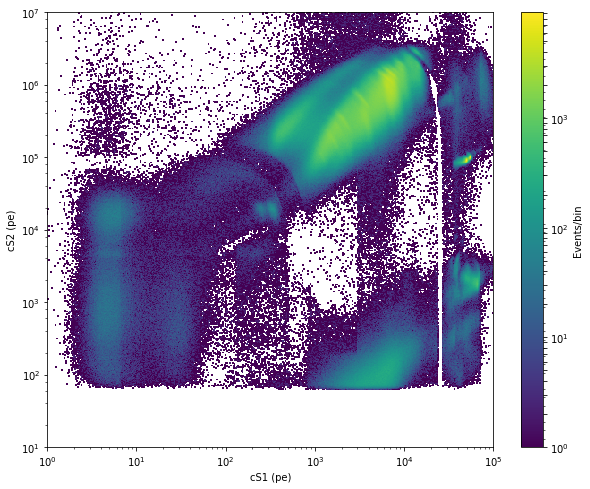

In [16]:
plt.figure(figsize=(10, 8))
mh.plot(log_scale=True, cblabel='Events/bin')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 (pe)')

The sharp features in the histogram are probably due to the application of various blinding cuts. Good look identifying all the populations...